In [1]:
# !pip install --upgrade torch torchvision
import torch
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)

Torch 1.9.0+cu102 CUDA 10.2


In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from numpy import load
import random
from PIL import Image

In [3]:
# Downloading dataset from Continual AI Colab's repository
!git clone https://github.com/ContinualAI/colab.git continualai/colab

Cloning into 'continualai/colab'...
remote: Enumerating objects: 360, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 360 (delta 142), reused 129 (delta 68), pack-reused 120
Receiving objects: 100% (360/360), 26.91 MiB | 24.85 MiB/s, done.
Resolving deltas: 100% (184/184), done.


In [4]:
# Import the script 
from continualai.colab.scripts import mnist
mnist.init()

Download complete.
Save complete.



Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw




Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw




Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw




Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# Loading dataset:
x_train, t_train, x_test, t_test = mnist.load()
print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


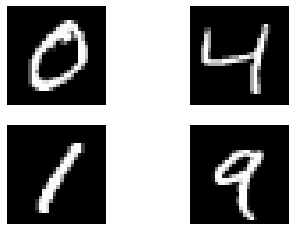

In [6]:
# Displaying 4 images inside dataset
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[1, 0], cmap="gray")
axarr[0,1].imshow(x_train[2, 0], cmap="gray")
axarr[1,0].imshow(x_train[3, 0], cmap="gray")
axarr[1,1].imshow(x_train[4, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

In [7]:
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
print(device)
torch.manual_seed(2)

cuda


* # **Part I:  instantiate model and start the training on original data**



In [8]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc4(x))
        return x

In [9]:
model = MLP().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer =  optim.Adadelta(model.parameters())

batch_size = 200

In [10]:
def train(model, device, x_train, t_train, optimizer, epoch):
    model.train()
    
    for start in range(0, len(t_train)-1, batch_size):
      end = start + batch_size
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
#     Reshape the input size for the input of MLP:
      x = x.view(x.size(0), -1)
#     Set the gradients to zero before starting to do backpropragation:
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
#   Use model.eval() for batch norm and dropouts
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, batch_size):
      end = start + batch_size
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0), -1)
        output = model(x)
        # sum up batch loss
        test_loss += F.cross_entropy(output, y).item() 
        # get the index of the max logit
        pred = output.max(1, keepdim=True)[1] 
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_train)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

In [11]:
for epoch in range(1, 11):
  train(model, device, x_train, t_train, optimizer, epoch)
  test(model, device, x_test, t_test)

Train Epoch: 1 	Loss: 0.348985
Test set: Average loss: 0.0004, Accuracy: 8338/10000 (83%)

Train Epoch: 2 	Loss: 0.336997
Test set: Average loss: 0.0003, Accuracy: 8579/10000 (86%)

Train Epoch: 3 	Loss: 0.101169
Test set: Average loss: 0.0001, Accuracy: 9705/10000 (97%)

Train Epoch: 4 	Loss: 0.090870
Test set: Average loss: 0.0001, Accuracy: 9748/10000 (97%)

Train Epoch: 5 	Loss: 0.103904
Test set: Average loss: 0.0001, Accuracy: 9784/10000 (98%)

Train Epoch: 6 	Loss: 0.055389
Test set: Average loss: 0.0001, Accuracy: 9785/10000 (98%)

Train Epoch: 7 	Loss: 0.053805
Test set: Average loss: 0.0001, Accuracy: 9775/10000 (98%)

Train Epoch: 8 	Loss: 0.065697
Test set: Average loss: 0.0001, Accuracy: 9779/10000 (98%)

Train Epoch: 9 	Loss: 0.041778
Test set: Average loss: 0.0001, Accuracy: 9772/10000 (98%)

Train Epoch: 10 	Loss: 0.044878
Test set: Average loss: 0.0001, Accuracy: 9769/10000 (98%)



In [12]:
# Load MNIST again for rotated 
x_train_2, t_train_2, x_test_2, t_test_2 = mnist.load()

print("x_train dim and type: ", x_train_2.shape, x_train_2.dtype)
print("t_train dim and type: ", t_train_2.shape, t_train_2.dtype)
print("x_test dim and type: ", x_test_2.shape, x_test_2.dtype)
print("t_test dim and type: ", t_test_2.shape, t_test_2.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


# **Part II:  Rotate MNIST for different tasks**

In [13]:
def rotate_dataset(d, seed):
    torch.manual_seed(seed)
    print("starting rotation...")
    rand_rotate = torch.rand(1)
#     print( rand_rotate)
#   for each rotation of each task, we rotate them for a random angle between 0 to 360
    rotation = 360*rand_rotate 
#     print(rotation)
    rotated_mnist = np.ndarray((d.shape),np.float32)
    result = []
    new_d=[]

    for i in range(d.shape[0]):
        img = Image.fromarray(d[i][0])
#       Use the roattion fuction from PIL's Image Library 
        img = img.rotate(rotation)
        rotated_mnist[i,0]= img

    return rotated_mnist

starting rotation...
starting rotation...
x_train dim and type:  (60000, 1, 28, 28) float32
x_test dim and type:  (10000, 1, 28, 28) float32


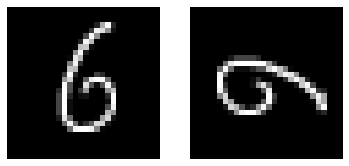

In [14]:
# Rotate MNIST dataset 
x_train_2 = rotate_dataset(x_train, 1)
x_test_2 = rotate_dataset(x_test, 1)
print("x_train dim and type: ", x_train_2.shape, x_train_2.dtype)
print("x_test dim and type: ", x_test_2.shape, x_test_2.dtype)

# Displat rotated MNIST dataset
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[18,0], cmap="gray")
axarr[1].imshow(x_train_2[18,0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

In [15]:
# Test our model trained by non-rorated on rotated which only has 18% accuracy.
print("Testing on the first task:")
test(model, device, x_test, t_test)

print("Testing on the second task:")
test(model, device, x_test_2, t_test);

Testing on the first task:
Test set: Average loss: 0.0001, Accuracy: 9769/10000 (98%)

Testing on the second task:
Test set: Average loss: 0.0063, Accuracy: 1429/10000 (14%)



In [16]:
# Finetune  our model using the new roated training set can reach a good acc of 97% 
for epoch in range(1, 3):
  train(model, device, x_train_2, t_train, optimizer, epoch)
  test(model, device, x_test_2, t_test)

Train Epoch: 1 	Loss: 0.119604
Test set: Average loss: 0.0001, Accuracy: 9589/10000 (96%)

Train Epoch: 2 	Loss: 0.205904
Test set: Average loss: 0.0001, Accuracy: 9676/10000 (97%)



In [17]:
# However if we use our finetuned model on the original dataset, the acc is still very low:
print("Testing on the first task:")
test(model, device, x_test, t_test);
print("Testing on the second task:")
test(model, device, x_test_2, t_test)

Testing on the first task:
Test set: Average loss: 0.0022, Accuracy: 4524/10000 (45%)

Testing on the second task:
Test set: Average loss: 0.0001, Accuracy: 9676/10000 (97%)



96.76

In [18]:
# task 1
task_1 = [(x_train, t_train), (x_test, t_test)]

# task 2
task_2 = [(x_train_2, t_train), (x_test_2, t_test)]

# task 3
x_train_3 = rotate_dataset(x_train, 4)
x_test_3 = rotate_dataset(x_test, 4)
task_3 = [(x_train_3, t_train), (x_test_3, t_test)]

# task 4
x_train_4 = rotate_dataset(x_train, 3)
x_test_4 = rotate_dataset(x_test, 3)
task_4 = [(x_train_4, t_train), (x_test_4, t_test)]

# task 5
x_train_5 = rotate_dataset(x_train, 9)
x_test_5 = rotate_dataset(x_test, 9)
task_5 = [(x_train_5, t_train), (x_test_5, t_test)]

# task 6
x_train_6 = rotate_dataset(x_train, 5)
x_test_6 = rotate_dataset(x_test, 5)
task_6 = [(x_train_6, t_train), (x_test_6, t_test)]

# task 7
x_train_7 = rotate_dataset(x_train, 8)
x_test_7 = rotate_dataset(x_test, 8)
task_7 = [(x_train_7, t_train), (x_test_7, t_test)]


# task 8
x_train_8 = rotate_dataset(x_train, 2)
x_test_8 = rotate_dataset(x_test, 2)
task_8 = [(x_train_8, t_train), (x_test_8, t_test)]

# task 9
x_train_9 = rotate_dataset(x_train, 0)
x_test_9 = rotate_dataset(x_test, 0)
task_9 = [(x_train_9, t_train), (x_test_9, t_test)]

# task 10
x_train_10 = rotate_dataset(x_train, 1)
x_test_10 = rotate_dataset(x_test, 1)
task_10 = [(x_train_10, t_train), (x_test_10, t_test)]


# task list
tasks=[task_1, task_2, task_3,task_4,task_5,task_6,task_7, task_8,task_9,task_10]
# tasks=[task_1, task_2, task_3]

starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...


* # **Part III: Implement Elastic Weights Consolidation (EWC) Strategy**

Accroding to paper Overcoming catastrophic forgetting in neural networks, EWC can prevent catastrophic forgetting by constraining important parameters to stay close to their old values when performing new tasks.

* **Inplementation of EWC:**

In [19]:
# Init dict/list for saving fisher information matrix and optmizated parameters from old task
fisher_dict = {}
optpar_dict = {}

ewc_lambda = 0.35

In [20]:
# Set up model and optimizer
model = MLP().to(device)

optimizer = optim.Adadelta(model.parameters())
batch_size = 200

In [21]:
def on_task_update(task_id, x_mem, t_mem):

  model.train()
  optimizer.zero_grad()
  
  # Satrt to accumulate gradients
  for start in range(0, len(t_mem)-1, batch_size):
      end = start + batch_size
      x, y = torch.from_numpy(x_mem[start:end]), torch.from_numpy(t_mem[start:end]).long()
      x, y = x.to(device), y.to(device)
    
#     Convert the input to the standard shape for MLP 
      x = x.view(x.size(0), -1)
        
      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()

  fisher_dict[task_id] = {}
  optpar_dict[task_id] = {}

# use the accumulated gradients, we can now calculate the Fisher Information matrix, which is a diagnal metrix that shows covariance 
  for name, param in model.named_parameters():
#   This is optmized parameters: 
    optpar_dict[task_id][name] = param.data.clone()
#   This is our Fisher Matrix:
    fisher_dict[task_id][name] = param.grad.data.clone().pow(2)
#   print(fisher_dict)

In [22]:
def train_ewc(model, device, task_id, x_train, t_train, optimizer, epoch, e_lambda):
    model.train()
    for start in range(0, len(t_train)-1,batch_size):
      end = start + batch_size
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
    
      x = x.view(x.size(0), -1)
#     Convert the input to the standard shape for MLP       
      optimizer.zero_grad()

#     output = F.log_softmax(model(x), dim=1)
      output = model(x)
      loss = F.cross_entropy(output, y)
      
#     Here we calculate our new EWC loss function which shown eailer 
      for task in range(task_id):
        for name, param in model.named_parameters():
          fisher = fisher_dict[task][name]
          optpar = optpar_dict[task][name]
#         Implementation of EWC loss funciton: optpar is optimized parameters, param is the paramters from the previous task: 
          loss += (fisher * (optpar - param).pow(2)).sum() * e_lambda
#     Do backprop     
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

In [23]:
ewc_accs = []

for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)
  
  (x_train, t_train), _ = task

  for epoch in range(1, 10):
    train_ewc(model, device, id, x_train, t_train, optimizer, epoch,ewc_lambda)
  on_task_update(id, x_train, t_train)
    
  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc
   
  print("Avg acc: ", avg_acc / 10)
  ewc_accs.append(avg_acc / 10)

Training on task:  0
Train Epoch: 1 	Loss: 0.170798
Train Epoch: 2 	Loss: 0.104710
Train Epoch: 3 	Loss: 0.066063
Train Epoch: 4 	Loss: 0.072901
Train Epoch: 5 	Loss: 0.054552
Train Epoch: 6 	Loss: 0.053350
Train Epoch: 7 	Loss: 0.041228
Train Epoch: 8 	Loss: 0.050859
Train Epoch: 9 	Loss: 0.036579
Testing on task:  0
Test set: Average loss: 0.0001, Accuracy: 9800/10000 (98%)

Testing on task:  1
Test set: Average loss: 0.0059, Accuracy: 1364/10000 (14%)

Testing on task:  2
Test set: Average loss: 0.0051, Accuracy: 3119/10000 (31%)

Testing on task:  3
Test set: Average loss: 0.0001, Accuracy: 9800/10000 (98%)

Testing on task:  4
Test set: Average loss: 0.0051, Accuracy: 1598/10000 (16%)

Testing on task:  5
Test set: Average loss: 0.0055, Accuracy: 1734/10000 (17%)

Testing on task:  6
Test set: Average loss: 0.0052, Accuracy: 2365/10000 (24%)

Testing on task:  7
Test set: Average loss: 0.0052, Accuracy: 2091/10000 (21%)

Testing on task:  8
Test set: Average loss: 0.0053, Accuracy

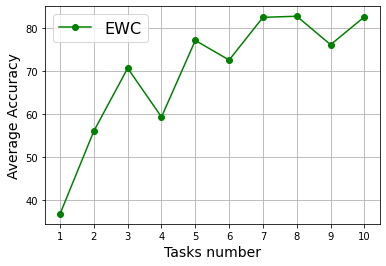

In [24]:
fig, ax = plt.subplots()
plt.plot([1, 2, 3,4,5,6,7,8,9,10], ewc_accs, '-o', label="EWC", color = 'g')
plt.xlabel('Tasks number', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)

ax.grid()
# plt.title('CL Strategies Comparison on MNSIT', fontsize=14);
plt.xticks([1, 2, 3,4,5,6,7,8,9,10])
plt.legend(prop={'size': 16});

**As we imporved the EWC model from the starter code, we can see the acc for EWC imporved from the benchmark's 74% to85.78%.**

# Part IV: Explore on the ewc lambda: 
Since the **$\lambda$** in our EWC loss function decides how important the previous task's parameters when compared to the new task, so we would want to find the best **$\lambda$**  that fits our model which provides better accurracy: 

In this part, we explores different  **$\lambda$** values and run each of them for three tasks and then plot them together to find the best **$\lambda$** value for our model. 

In [25]:
lam_dic = []
for i in range(10,100,5):
    test_lam = round(i*0.01,2)
    lam_dic.append(test_lam)

In [26]:
i = 0
lam_acc =[]

for lambda_i in lam_dic: 
    print("current lambda: ", lambda_i)
    lam_diff_ewc_acc = []
    model = MLP().to(device)
    optimizer = optim.Adadelta(model.parameters())
    for id, task in enumerate(tasks[:3]):
        avg_acc = 0
        print("Training on task: ", id)

        (x_train, t_train), _ = task

        for epoch in range(1, 3):
            train_ewc(model, device, id, x_train, t_train, optimizer, epoch,lambda_i)
            on_task_update(id, x_train, t_train)

        for id_test, task in enumerate(tasks[:3]):
            print("Testing on task: ", id_test)
            _, (x_test, t_test) = task
            acc = test(model, device, x_test, t_test)
            avg_acc = avg_acc + acc

        print("Avg acc: ", avg_acc / 3)
        lam_diff_ewc_acc.append(avg_acc / 3)
    lam_acc.append(lam_diff_ewc_acc)

current lambda:  0.1
Training on task:  0
Train Epoch: 1 	Loss: 0.143398
Train Epoch: 2 	Loss: 0.097843
Testing on task:  0
Test set: Average loss: 0.0001, Accuracy: 9675/10000 (97%)

Testing on task:  1
Test set: Average loss: 0.0043, Accuracy: 1727/10000 (17%)

Testing on task:  2
Test set: Average loss: 0.0033, Accuracy: 2990/10000 (30%)

Avg acc:  47.97333333333333
Training on task:  1
Train Epoch: 1 	Loss: 0.137269
Train Epoch: 2 	Loss: 0.130452
Testing on task:  0
Test set: Average loss: 0.0022, Accuracy: 4403/10000 (44%)

Testing on task:  1
Test set: Average loss: 0.0001, Accuracy: 9658/10000 (97%)

Testing on task:  2
Test set: Average loss: 0.0034, Accuracy: 2326/10000 (23%)

Avg acc:  54.623333333333335
Training on task:  2
Train Epoch: 1 	Loss: 0.197874
Train Epoch: 2 	Loss: 0.133225
Testing on task:  0
Test set: Average loss: 0.0026, Accuracy: 3913/10000 (39%)

Testing on task:  1
Test set: Average loss: 0.0012, Accuracy: 6312/10000 (63%)

Testing on task:  2
Test set: Ave

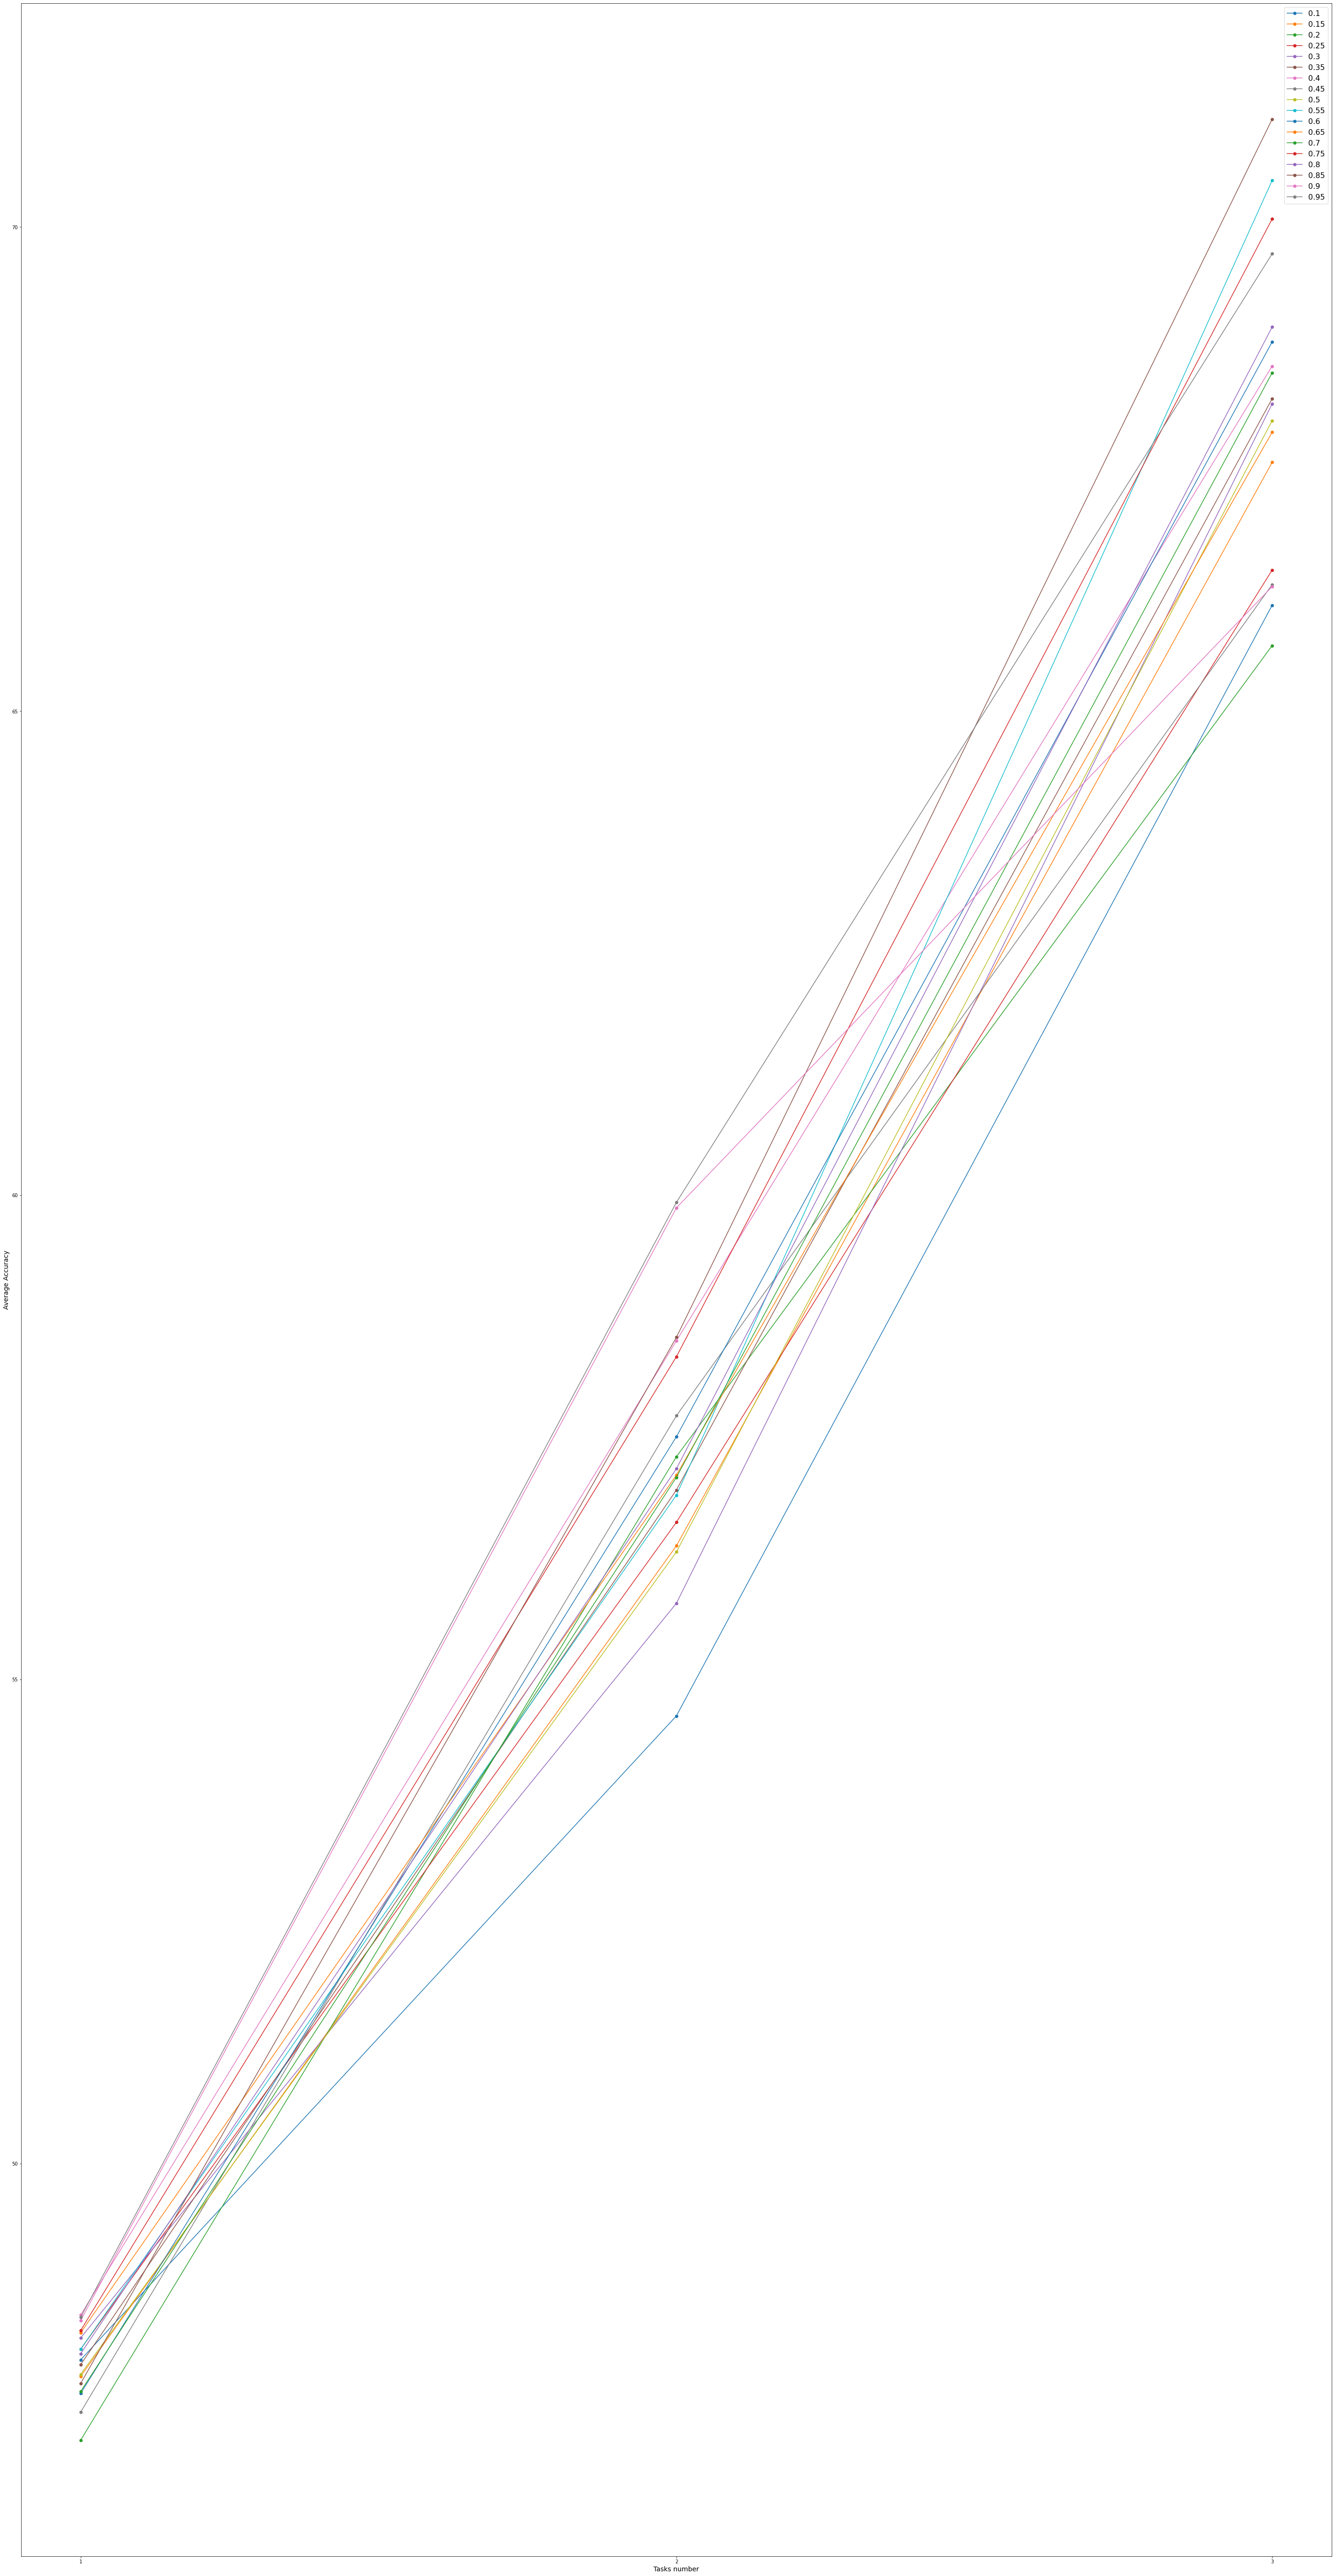

In [27]:
fig, ax = plt.subplots(figsize=(50,100))

n = 0.1
for i in lam_acc: 
    plt.plot([1, 2, 3],i, '-o', label= n)
    plt.xlabel('Tasks number', fontsize=14)
    plt.ylabel('Average Accuracy', fontsize=14)
    ax.grid()
    # plt.title('CL Strategies Comparison on MNSIT', fontsize=14);
    plt.xticks([1, 2, 3])
    plt.legend(prop={'size': 16})
    n += 0.05
    n = round(n,2)